In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [2]:
df = pd.read_csv("/Users/r3alistic/Programming/CoffeeCV/features_v2.csv")
df.head()

,Video_Name,Category,Pull_Duration,Frames_Processed,color_progression,color_consistency,mid_phase_intensity,color_change_rate,flow_steadiness,flow_amplitude,flow_trend,brightness_momentum,brightness_acceleration,brightness_trend,overall_steadiness,phase_uniformity,transition_1_2_smoothness,transition_2_3_smoothness,overall_transition_quality
0,vid_79_good,good,31.24,420,1.394,0.712,20.338,0.00332,0.0002,383,-39.24,0.101,0.1160,1.72,0.6761,0.4750,0.6590,0.8116,0.7353
1,vid_80_good,good,29.37,420,0.507,0.901,17.916,0.00121,0.0013,111,-18.66,0.062,0.0942,0.91,0.8465,0.6028,0.7143,0.7036,0.7090
2,vid_43_good,good,28.56,420,1.512,0.639,16.880,0.00360,0.0005,304,45.11,0.358,0.3824,0.06,0.8897,0.5594,0.6030,0.9343,0.7687
3,vid_14_good,good,27.28,420,2.784,0.373,17.099,0.00663,0.0009,227,-0.84,0.297,0.3509,13.32,0.7904,0.3289,0.7735,0.6900,0.7317
4,vid_22_good,good,25.65,420,4.956,0.155,19.943,0.01180,0.0002,359,57.24,0.262,0.2209,0.82,0.8354,0.1674,0.5150,0.5649,0.5400


Right now there are no missing values, but just drop them if there are.

In [3]:
df.dropna(axis=0,inplace=True)

In [4]:
df.isna().sum().sum()

0

Now just for sanity, check for duplicates

In [5]:
len(df["Video_Name"]) == len(set(df["Video_Name"]))

True

Idea: check the average stream width for each category, so use groupby

In [ ]:
df.describe()

,Pull_Duration,Frames_Processed,color_progression,color_consistency,mid_phase_intensity,color_change_rate,flow_steadiness,flow_amplitude,flow_trend,brightness_momentum,brightness_acceleration,brightness_trend,overall_steadiness,phase_uniformity,transition_1_2_smoothness,transition_2_3_smoothness,overall_transition_quality
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,28.443951,414.493827,1.388938,0.650123,18.400988,0.003668,0.004125,221.382716,13.470741,0.229654,0.275609,3.668025,0.774635,0.401763,0.769296,0.773744,0.771519
std,8.367780,24.483731,1.303075,0.237041,2.800842,0.002854,0.008733,120.847587,66.064600,0.168697,0.251767,4.450228,0.138096,0.144173,0.125520,0.114413,0.095987
min,8.640000,256.000000,-1.923000,0.139000,12.749000,0.000000,0.000000,33.000000,-151.380000,0.043000,0.050300,-5.700000,0.338700,0.144800,0.439500,0.410600,0.540000
25%,25.010000,420.000000,0.664000,0.445000,16.143000,0.001810,0.000200,116.000000,-14.210000,0.102000,0.112800,1.350000,0.691000,0.318600,0.677700,0.701100,0.709000
50%,28.900000,420.000000,1.127000,0.714000,18.183000,0.002780,0.000900,219.000000,0.850000,0.188000,0.183400,2.710000,0.819500,0.369600,0.753900,0.772500,0.760600
75%,31.100000,420.000000,1.946000,0.827000,20.899000,0.004760,0.003100,348.000000,22.940000,0.297000,0.346200,4.430000,0.879900,0.500100,0.869800,0.849800,0.842100
max,68.000000,420.000000,5.475000,0.994000,24.348000,0.013040,0.056500,383.000000,286.500000,0.848000,1.244900,19.000000,0.949800,0.861400,0.994300,0.989200,0.971500


# Data Preprocessing + Model Building --> Pipeline

(Even with an abysmally low amount of data)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [18]:
# Separate features and target
X = df.drop(columns=["Category", "Video_Name","Frames_Processed"])
y = df["Category"].to_numpy()

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

predictors_num = list(X.columns)

preprocessor = ColumnTransformer([
    ("scaler",StandardScaler(),predictors_num),
],remainder="drop")

# Encode target labels as integers (ex: good = 0, under = 1, over = 2). OneHotEncoder would be too much here. Just labels in the same column is fine
#pipeline .fit and .predict calls know to do fit_transform on train data and just .transform on test data and unseen data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y_encoded)

#Using a pipeline no matter what. When we save the best one with joblib, it will have all the preprocessing built into it.
pipeline_1 = Pipeline([
    ("preprocessor",preprocessor),
    ("classifier",LogisticRegression())
])

#y_test is encoded for future reference testing
pipeline_1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Pull_Duration',
                                                   'color_progression',
                                                   'color_consistency',
                                                   'mid_phase_intensity',
                                                   'color_change_rate',
                                                   'flow_steadiness',
                                                   'flow_amplitude',
                                                   'flow_trend',
                                                   'brightness_momentum',
                                                   'brightness_acceleration',
                                                   'brightness_trend',
                                                   'overall_steadiness',
                                                   'phase_uniformity',
                                                   'transition_1_2_smoothness',
                                                   'transition_2_3_smoothness',
                                                   'overall_transition_quality'])])),
                ('classifier', LogisticRegression())])

In [20]:
y_pred_1 = pipeline_1.predict(X_test)

# Validation Strategies

In [19]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

## Training Scores - Model 1

In [33]:
y_pred_train_1 = pipeline_1.predict(X_train)

In [36]:
print(classification_report(y_train,y_pred_train_1))

              precision    recall  f1-score   support

        good       0.92      0.96      0.94        47
        over       1.00      1.00      1.00         3
       under       0.83      0.71      0.77        14

    accuracy                           0.91        64
   macro avg       0.92      0.89      0.90        64
weighted avg       0.90      0.91      0.90        64



In [37]:
print("LogReg's Accuracy Score:",accuracy_score(y_train,y_pred_train_1))

LogReg's Accuracy Score: 0.90625


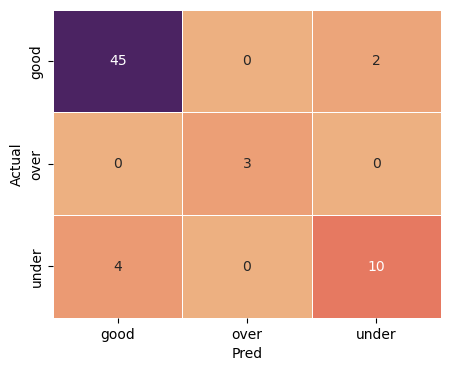

In [38]:
cm = confusion_matrix(y_train,y_pred_train_1)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="flare",linewidth=0.5,xticklabels=encoder.classes_, yticklabels=encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

In [40]:
cv_scores = cross_val_score(pipeline_1,X_train,y_train,cv=5,scoring="accuracy")
print(sorted(cv_scores))
print("mean",cv_scores.mean())

[0.6153846153846154, 0.7692307692307693, 0.7692307692307693, 0.8333333333333334, 0.9230769230769231]
mean 0.7820512820512822


/opt/anaconda3/envs/coffeecv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


## Testing Scores - Model 1

In [41]:
print(classification_report(y_test,y_pred_1))

              precision    recall  f1-score   support

        good       0.71      0.83      0.77        12
        over       0.33      1.00      0.50         1
       under       0.00      0.00      0.00         4

    accuracy                           0.65        17
   macro avg       0.35      0.61      0.42        17
weighted avg       0.52      0.65      0.57        17



/opt/anaconda3/envs/coffeecv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/coffeecv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/coffeecv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [24]:
print("LogReg's Accuracy Score:",accuracy_score(y_test,y_pred_1))

LogReg's Accuracy Score: 0.6470588235294118


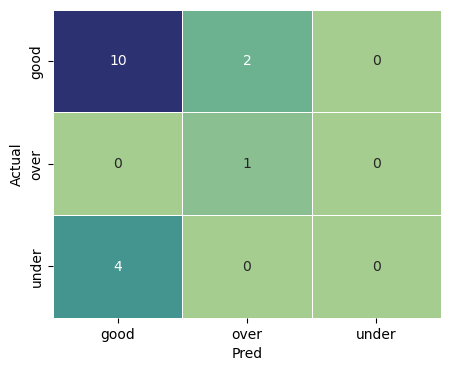

In [39]:
cm = confusion_matrix(y_test,y_pred_1)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="crest",linewidth=0.5,xticklabels=encoder.classes_, yticklabels=encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

These warnings will go away once we have a lot more overextracted shots. 

<p style="color:lightpink">So far, what are the notable feats: 90% train accuracy, more incorrect estimates than we'd like, solid preprocessing, but the model will overfit without enough data. <u>What we need to keep in mind is that training score DOWN and testing score UP is fine and actually what we want anyway.</u></p>